# Extended Aperture Photometry

**Use case:** Measure galaxy photometry in a field. Related to [JDox Science Use Case #22](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-example-science-programs/nircam-deep-field-imaging-with-miri-imaging-parallels).<br>
**Data:** WST simulated NIRCam images from [JADES JWST GTO extragalactic blank field](http://fenrir.as.arizona.edu/jwstmock/).<br>
(Williams et al. 2018) https://ui.adsabs.harvard.edu/abs/2018ApJS..236...33W.<br>
**Tools:**  photutils, matplotlib, scipy, scikit.<br>
**Cross-intrument:** potentially MIRI.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

## Introduction

This notebook uses `photutils` to detect objects/galaxies in NIRCam deep imaging.  Detections are first made in a F200W image, then isophotal photometry is obtained in all 9 filters (F090W, F115W, F150W, F200W, F277W, F335M, F356W, F410M, F444W). The catalog is loaded back in and some simple analysis is performed on the full catalog and on an individual galaxy.

The notebook analyzes only the central 1000 x 1000 pixels (30" x 30") of the full JADES simulation. These cutouts have been staged at STScI with permission from the authors (Williams et al.).

**NOTE:** The photometry is aperture matched, but no PSF corrections are made. For more accurate color measurements, PSF corrections should be implemented, given the large range of wavelengths (and thus PSF FWHM) spanning a factor of >4.

**NOTE:** The simulated JADES images have different units (e-/s) than JWST pipeline products (MJy/sr).

**NOTE:** An exposure map is missing but required to calculate flux uncertainties.

# To Do
* PSF corrections
* Check accuracy of photometry against simulated JADES catalog
* Exposure map required for input to error calculation
* ABmag units cannot be written to ecsv file (astropy update coming soon)
* plot with text labels looks horrible (I wish cursor hover would show id number instead)
* Fix plot secondary axis: mag vs. flux
* requirements.txt file -- but I don't know what versions are "required"
* rest of Robel's comments: https://github.com/spacetelescope/dat_pyinthesky/pull/82#pullrequestreview-355206337

## Download WEBBPSF Data

In [3]:
import os
import tarfile
import urllib.request

boxlink = 'https://stsci.box.com/shared/static/34o0keicz2iujyilg4uz617va46ks6u9.gz'                                                           
boxfile = './webbpsf-data/webbpsf-data-1.0.0.tar.gz'

webbpsf_folder = './webbpsf-data'

# Check whether the specified path exists or not
isExist = os.path.exists(webbpsf_folder)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(webbpsf_folder)
    
urllib.request.urlretrieve(boxlink, boxfile)
gzf = tarfile.open(boxfile)
gzf.extractall(webbpsf_folder)


## Import packages

In [9]:
import os

import numpy as np

from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import QTable
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, ImageNormalize, simple_norm
import astropy.wcs as wcs

import photutils
print('photutils', photutils.__version__)

from photutils import Background2D, MedianBackground, detect_sources, deblend_sources, SourceCatalog#, source_properties (new API)
from photutils.utils import calc_total_error

photutils 1.3.0


## Matplotlib setup for plotting
There are two versions
 - `notebook` -- gives interactive plots, but makes the overall notebook a bit harder to scroll
 - `inline` -- gives non-interactive plots for better overall scrolling

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version if you want interactive plots
# %matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

## Create list of images to be loaded and analyzed

In [11]:
baseurl = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/'

filters = 'F090W F115W F150W F200W F277W F335M F356W F410M F444W'.split()

# Data images [e-/s]
imagefiles = {}
for filt in filters:
    filename = f'jades_jwst_nircam_goods_s_crop_{filt}.fits'
    imagefiles[filt] = os.path.join(baseurl, filename)

# Weight images (Inverse Variance Maps; IVM)
weightfiles = {}
for filt in filters:
    filename = f'jades_jwst_nircam_goods_s_crop_{filt}_wht.fits'
    weightfiles[filt] = os.path.join(baseurl, filename)

## Load detection image: F200W

In [12]:
filt = 'F200W'
infile = imagefiles[filt]
hdu = fits.open(infile)
data = hdu[0].data
imwcs = wcs.WCS(hdu[0].header, hdu)

weight = fits.open(weightfiles[filt])[0].data

## Report image size and field of view

In [13]:
ny, nx = data.shape
pixscale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
pixscale *= imwcs.wcs.cunit[0].to('arcsec')
outline = '%d x %d pixels' % (ny, nx)
outline += ' = %g" x %g"' % (ny * pixscale, nx * pixscale)
outline += ' (%.2f" / pixel)' % pixscale
print(outline)

1000 x 1000 pixels = 30" x 30" (0.03" / pixel)


## Create color image (optional)

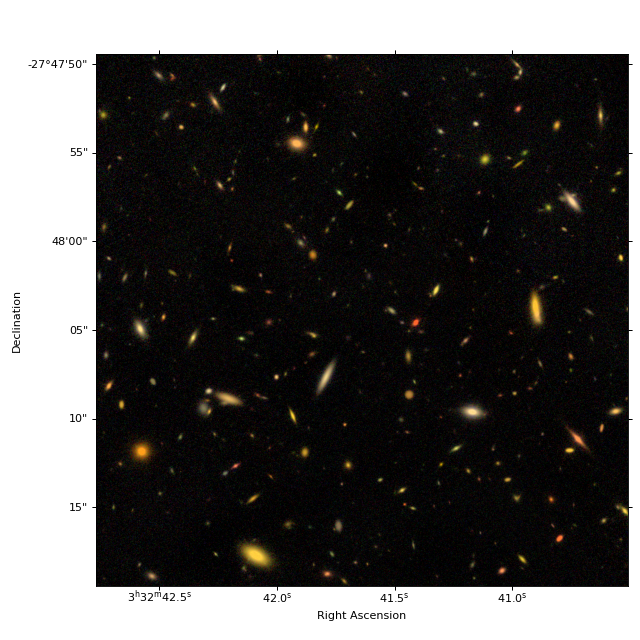

In [14]:
# 3 NIRCam short wavelength channel images
r = fits.open(imagefiles['F200W'])[0].data
g = fits.open(imagefiles['F150W'])[0].data
b = fits.open(imagefiles['F090W'])[0].data

rgb = make_lupton_rgb(r, g, b, Q=5, stretch=0.02)  # , minimum=-0.001

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=imwcs)
plt.imshow(rgb, origin='lower')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
fig.tight_layout()
plt.subplots_adjust(left=0.15)

## Detect Sources and Deblend using `photutils`
https://photutils.readthedocs.io/en/latest/segmentation.html

In [15]:
# For detection, requiring 5 connected pixels 2-sigma above background

# Measure background and set detection threshold
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = bkg.background + (2. * bkg.background_rms)

# Before detection, smooth image with Gaussian FWHM = 3 pixels
sigma = 3.0 * gaussian_fwhm_to_sigma  
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

# Detect and deblend
segm_detect = detect_sources(data, threshold, npixels=5, kernel=kernel)

segm_deblend = deblend_sources(data, segm_detect, npixels=5, kernel=kernel, nlevels=32, contrast=0.001)

# Save segmentation map of detected objects
segm_hdu = fits.PrimaryHDU(segm_deblend.data.astype(np.uint32), header=imwcs.to_header())
segm_hdu.writeto('JADES_detections_segm.fits', overwrite=True)

## Measure photometry (and more) in detection image
https://photutils.readthedocs.io/en/latest/segmentation.html#centroids-photometry-and-morphological-properties

In [16]:
#error = bkg.background_rms
# Input weight should be exposure map. Fudging for now.
error = calc_total_error(data, bkg.background_rms, weight/500)
#cat = source_properties(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=error)
cat = SourceCatalog(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=error)

## Show detections alongside images (optional)

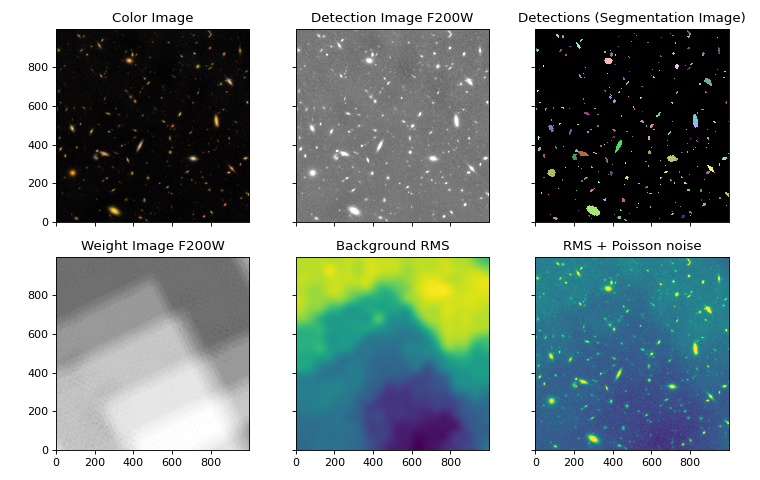

In [17]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9.5, 6))
# For RA,Dec axes instead of pixels, add: , subplot_kw={'projection': imwcs})

# Color image
ax[0, 0].imshow(rgb, origin='lower')
ax[0, 0].set_title('Color Image')

# Data
norm = simple_norm(data, 'sqrt', percent=99.)
ax[0, 1].imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax[0, 1].set_title('Detection Image F200W')

# Segmentation map
cmap = segm_deblend.make_cmap(seed=12345)
ax[0, 2].imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
ax[0, 2].set_title('Detections (Segmentation Image)')

# Weight
ax[1, 0].imshow(weight, origin='lower', cmap='Greys_r', vmin=0)
ax[1, 0].set_title('Weight Image F200W')

# RMS
ax[1, 1].imshow(bkg.background_rms, origin='lower', norm=None)
ax[1, 1].set_title('Background RMS')

# Total error including Poisson noise
norm = simple_norm(error, 'sqrt', percent=99.)
ax[1, 2].imshow(error, origin='lower', norm=norm)
ax[1, 2].set_title('RMS + Poisson noise')

fig.tight_layout()

## View all measured quantities in detection image (optional)

In [18]:
cat.to_table()

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,466.2446191621408,8.797561129665855,"53.17381009097992,-27.805320830391864",460,472,3,14,101.0,3.121879020447465,1.6877163631442755,-44.478942893072606,0.8412738835304273,0.0006696563376710548,0.030035612040483474,0.0,0.8863553255951271,0.043331074386756534,1.1523408689896644,0.055428235204898674
2,104.80681792778353,18.082127698954903,"53.17721522973061,-27.805243193462598",95,116,10,27,271.0,4.433066393534528,2.8904231048306737,-26.54969453207091,0.7582065866565184,0.001169509769846069,0.056832804145585177,0.0,3.3850685305729327,0.10096380189395227,4.064225100060504,0.11784842568293828
3,15.044163921901813,13.21870975665332,"53.178060898532195,-27.80528364304473",14,16,12,14,8.0,0.8501945161500964,0.6682677793754631,-38.16121831820679,0.6182042290711056,0.003572803334355115,0.006067328251788077,0.0,0.04072222141038691,0.011222850843720303,0.10086797685330892,0.023152382498386796
4,710.3242890392038,14.25977714999582,"53.171510585054484,-27.805275444028336",708,712,12,17,25.0,1.2749752921546111,1.1173719529864645,-59.261779367773485,0.4816072845662932,0.0013530624221137692,0.015100954603196246,0.0,0.15496898030720482,0.01857521225593666,0.1901167632563189,0.023625575821143968
5,434.5293005320276,22.22194182036222,"53.17410887499959,-27.805208940611234",424,447,14,30,268.0,3.9541018651718662,2.631730771284544,-8.167279706892074,0.7463356127202322,-0.0003422117037313625,0.10656049549533983,0.0,3.616283441199554,0.08775124764202687,4.277313658552826,0.1008163850310633
6,289.38777064761285,17.281737451378522,"53.17547627296228,-27.80525000942734",287,291,15,20,17.0,1.2912455490105954,1.1977463179669274,68.1638381270016,0.37360004583742673,0.0019617333452204627,0.008807085091569026,0.0,0.0853121904333309,0.01664131060377364,0.3476470446224146,0.04605050169106774
7,640.4863091357875,17.77342928811143,"53.17216853452835,-27.805246129691128",638,642,15,20,21.0,1.5124915816036382,0.8803105984042895,-64.72678433137519,0.8131696209603629,0.0003576229226789255,0.00994693380687687,0.0,0.09708319194042785,0.01446248864576078,0.1769579898710676,0.02607370310029703
8,762.7604138721657,28.298130100126222,"53.17101657158964,-27.805158481181316",754,771,21,36,201.0,3.160486655681075,2.36398722007272,37.84866098717489,0.6637189803634264,-0.00019417752395444783,0.10556122020166694,0.0,3.825351842031478,0.08853590615348698,3.981147346110262,0.09151504744064401


## Only keep some quantities

In [19]:
columns = 'label xcentroid ycentroid sky_centroid area semimajor_sigma semiminor_sigma ellipticity orientation gini'.split()
tbl = cat.to_table(columns=columns)
tbl.rename_column('semimajor_sigma', 'a')
tbl.rename_column('semiminor_sigma', 'b')

In [20]:
tbl

label,xcentroid,ycentroid,sky_centroid,area,a,b,ellipticity,orientation,gini
,,,"deg,deg",pix2,pix,pix,,deg,
int64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64
1,466.2446191621408,8.797561129665855,"53.17381009097992,-27.805320830391864",101.0,3.121879020447465,1.6877163631442755,0.45939085016101233,-44.478942893072606,0.37508586167557634
2,104.80681792778353,18.082127698954903,"53.17721522973061,-27.805243193462598",271.0,4.433066393534528,2.8904231048306737,0.3479856044912265,-26.54969453207091,0.42920642250826463
3,15.044163921901813,13.21870975665332,"53.178060898532195,-27.80528364304473",8.0,0.8501945161500964,0.6682677793754631,0.21398248673544173,-38.16121831820679,0.1052114683080948
4,710.3242890392038,14.25977714999582,"53.171510585054484,-27.805275444028336",25.0,1.2749752921546111,1.1173719529864645,0.12361285754942664,-59.261779367773485,0.33737607984284185
5,434.5293005320276,22.22194182036222,"53.17410887499959,-27.805208940611234",268.0,3.9541018651718662,2.631730771284544,0.3344302041216748,-8.167279706892074,0.5358662617523409
6,289.38777064761285,17.281737451378522,"53.17547627296228,-27.80525000942734",17.0,1.2912455490105954,1.1977463179669274,0.07241010907283352,68.1638381270016,0.18003661350655398
7,640.4863091357875,17.77342928811143,"53.17216853452835,-27.805246129691128",21.0,1.5124915816036382,0.8803105984042895,0.4179732243726414,-64.72678433137519,0.2573400602701095
8,762.7604138721657,28.298130100126222,"53.17101657158964,-27.805158481181316",201.0,3.160486655681075,2.36398722007272,0.2520179714021643,37.84866098717489,0.542497845222606


## Convert measured fluxes (data units) to magnitudes

https://docs.astropy.org/en/stable/units/

https://docs.astropy.org/en/stable/units/equivalencies.html#photometric-zero-point-equivalency

https://docs.astropy.org/en/stable/units/logarithmic_units.html#logarithmic-units

In [21]:
# not detected: mag =  99; magerr = 1-sigma upper limit assuming zero flux
# not observed: mag = -99; magerr = 0
def fluxes2mags(flux, fluxerr):
    nondet = flux < 0  # Non-detection if flux is negative
    unobs = (fluxerr <= 0) + (fluxerr == np.inf)  # Unobserved if flux uncertainty is negative or infinity

    mag = flux.to(u.ABmag)
    magupperlimit = fluxerr.to(u.ABmag)  # 1-sigma upper limit if flux=0

    mag = np.where(nondet, 99 * u.ABmag, mag)
    mag = np.where(unobs, -99 * u.ABmag, mag)

    magerr = 2.5 * np.log10(1 + fluxerr/flux) 
    magerr = magerr.value * u.ABmag

    magerr = np.where(nondet, magupperlimit, magerr)
    magerr = np.where(unobs, 0*u.ABmag, magerr)
    
    return mag, magerr

# Includes features I couldn't find in astropy:
# mag = 99 / -99 for non-detections / unobserved
# flux uncertainties -> mag uncertainties

## Multiband photometry using isophotal apertures defined in detection image
(Similar to running SourceExtractor in double-image mode)

In [22]:
filters = 'F090W F115W F150W F200W F277W F335M F356W F410M F444W'.split()
for filt in filters:
    infile = imagefiles[filt]
    print(filt)
    print(infile)
    print(weightfiles[filt])
    hdu = fits.open(infile)
    data = hdu[0].data
    zp = hdu[0].header['ABMAG'] * u.ABmag  # zeropoint
    weight = fits.open(weightfiles[filt])[0].data
    
    # Measure background
    bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    #error = bkg.background_rms
    error = calc_total_error(data, bkg.background_rms, weight/500)
                             
    # Measure properties in each image of previously detected objects 
    filtcat = SourceCatalog(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=error)

    # Convert measured fluxes to fluxes in nJy and to AB magnitudes
    filttbl = filtcat.to_table()
    tbl[filt+'_flux']    = flux    = filttbl['segment_flux']     * zp.to(u.nJy)
    tbl[filt+'_fluxerr'] = fluxerr = filttbl['segment_fluxerr'] * zp.to(u.nJy)

    mag, magerr = fluxes2mags(flux, fluxerr)
    #mag = mag * u.ABmag  # incompatible with file writing
    tbl[filt+'_mag']    = mag.value
    tbl[filt+'_magerr'] = magerr.value

F090W
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F090W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F090W_wht.fits


/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:46: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


F115W
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F115W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F115W_wht.fits


/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:46: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


F150W
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F150W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F150W_wht.fits
F200W
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F200W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F200W_wht.fits
F277W
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F277W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F277W_wht.fits
F335M
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F335M.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data

/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:46: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


F444W
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F444W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F444W_wht.fits


/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:46: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## View complete results (optional)

In [23]:
tbl

label,xcentroid,ycentroid,sky_centroid,area,a,b,ellipticity,orientation,gini,F090W_flux,F090W_fluxerr,F090W_mag,F090W_magerr,F115W_flux,F115W_fluxerr,F115W_mag,F115W_magerr,F150W_flux,F150W_fluxerr,F150W_mag,F150W_magerr,F200W_flux,F200W_fluxerr,F200W_mag,F200W_magerr,F277W_flux,F277W_fluxerr,F277W_mag,F277W_magerr,F335M_flux,F335M_fluxerr,F335M_mag,F335M_magerr,F356W_flux,F356W_fluxerr,F356W_mag,F356W_magerr,F410M_flux,F410M_fluxerr,F410M_mag,F410M_magerr,F444W_flux,F444W_fluxerr,F444W_mag,F444W_magerr
,,,"deg,deg",pix2,pix,pix,,deg,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,
int64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,466.2446191621408,8.797561129665855,"53.17381009097992,-27.805320830391864",101.0,3.121879020447465,1.6877163631442755,0.45939085016101233,-44.478942893072606,0.37508586167557634,9.172811394018415,0.8464272458406787,28.99374384027416,0.09583064233805802,15.251726376079008,0.7351765095308295,28.44170248699463,0.0511133289791888,18.356091918336602,0.9076162764010919,28.240549440593583,0.052399168008756436,20.355785154984098,0.9951291714293272,28.12828035383283,0.05182154853679,15.304953562433628,0.37203714445031283,28.43791995945107,0.02607671169612288,14.020837880438183,0.45364676842999707,28.533065080763322,0.03457285577978178,14.174921764666534,0.4003191726828091,28.52119832355102,0.030237680138331825,13.880657302109446,0.46501604739495567,28.543974919731706,0.03577726408515742,13.807587823709035,0.4986394368767425,28.54970546437063,0.03851826366620073
2,104.80681792778353,18.082127698954903,"53.17721522973061,-27.805243193462598",271.0,4.433066393534528,2.8904231048306737,0.3479856044912265,-26.54969453207091,0.42920642250826463,66.57967763727589,2.436255937144689,26.841645779808214,0.039019197397681976,67.80798783122103,1.7819362357086113,26.821797857268766,0.028163763805507894,70.39372361542223,2.109674864435216,26.781165153306027,0.03206106305962543,77.74052431734964,2.3187060543735596,26.67338133653986,0.03190986357436147,72.93102944850699,0.8316396948346881,26.74271914041546,0.012310699210640685,75.27250253951972,1.0706031059098788,26.708409112497108,0.01533367028926019,71.47848555139554,0.9342284245501049,26.76456164418066,0.014098706249330848,61.4274821006001,0.9993076263063927,26.92909321488465,0.017520720091398885,57.221978597423586,1.0510852420375645,27.006092823549594,0.019762455337137535
3,15.044163921901813,13.21870975665332,"53.178060898532195,-27.80528364304473",8.0,0.8501945161500964,0.6682677793754631,0.21398248673544173,-38.16121831820679,0.1052114683080948,0.3018945766985653,0.22003285556303284,32.70036172167414,0.5943870310993591,0.7673345839553668,0.2004972158384962,31.68753806900193,0.2520377877672825,0.718527131468952,0.22413716175198545,31.75889207082583,0.2947847131692354,0.9352149934981862,0.25774081116714,31.472721347800608,0.26428223454246347,0.34976093623859705,0.06899828286174059,32.540571743027996,0.19548269618701286,0.5607617346802108,0.11336299849737182,32.02805407366013,0.19990472716017474,0.26684999693725037,0.07056578126665071,32.834331994612434,0.2547454625234373,-0.06031707733396127,0.08275801332641672,99.0,34.105474858685724,0.1176584868084009,0.08200731535238008,33.72344185330393,0.5742010715062489
4,710.3242890392038,14.25977714999582,"53.171510585054484,-27.805275444028336",25.0,1.2749752921546111,1.1173719529864645,0.12361285754942664,-59.261779367773485,0.33737607984284185,2.6566768932429503,0.43714872230622887,30.339153153882492,0.1653927311539301,3.818279769007211,0.3605579188578186,29.945330634012084,0.09796939111646247,3.976176731338656,0.4246249945145132,29.90133580129333,0.11016530693858104,3.55

## Save photometry as output catalog

In [24]:
tbl.write('JADESphotometry.ecsv', overwrite=True)

In [25]:
!head -175 JADESphotometry.ecsv  # show the first 175 lines

==> JADESphotometry.ecsv <==
# %ECSV 1.0
# ---
# datatype:
# - {name: label, datatype: int64}
# - {name: xcentroid, datatype: float64}
# - {name: ycentroid, datatype: float64}
# - {name: sky_centroid.ra, unit: deg, datatype: float64}
# - {name: sky_centroid.dec, unit: deg, datatype: float64}
# - {name: area, unit: pix2, datatype: float64}
# - {name: a, unit: pix, datatype: float64}
# - {name: b, unit: pix, datatype: float64}
# - {name: ellipticity, datatype: float64}
# - {name: orientation, unit: deg, datatype: float64}
# - {name: gini, datatype: float64}
# - {name: F090W_flux, unit: nJy, datatype: float64}
# - {name: F090W_fluxerr, unit: nJy, datatype: float64}
# - {name: F090W_mag, datatype: float64}
# - {name: F090W_magerr, datatype: float64}
# - {name: F115W_flux, unit: nJy, datatype: float64}
# - {name: F115W_fluxerr, unit: nJy, datatype: float64}
# - {name: F115W_mag, datatype: float64}
# - {name: F115W_magerr, datatype: float64}
# - {name: F150W_flux, unit: nJy, datatype: float6

## Reformat output catalog for readability (optional)

In [26]:
# Remove units (pixels) from area
tbl['area'] = tbl['area'].value.astype(int)

# Replace sky_centroid with ra, dec
tbl['ra'] = tbl['sky_centroid'].ra.degree
tbl['dec'] = tbl['sky_centroid'].dec.degree

columns = list(tbl.columns)
columns = columns[:3] + ['ra', 'dec'] + columns[4:-2]

tbl = tbl[columns]

In [27]:
for column in columns:
    tbl[column].info.format = '.4f'

tbl['ra'].info.format = '11.7f'
tbl['dec'].info.format = '11.7f'

tbl['label'].info.format = 'd'
tbl['area'].info.format = 'd'

In [28]:
tbl.write('JADESphotometry.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

In [29]:
!head -10 JADESphotometry.cat  # show the first 10 lines

==> JADESphotometry.cat <==
label xcentroid ycentroid          ra         dec area       a      b ellipticity orientation   gini F090W_flux F090W_fluxerr F090W_mag F090W_magerr F115W_flux F115W_fluxerr F115W_mag F115W_magerr F150W_flux F150W_fluxerr F150W_mag F150W_magerr F200W_flux F200W_fluxerr F200W_mag F200W_magerr F277W_flux F277W_fluxerr F277W_mag F277W_magerr F335M_flux F335M_fluxerr F335M_mag F335M_magerr F356W_flux F356W_fluxerr F356W_mag F356W_magerr F410M_flux F410M_fluxerr F410M_mag F410M_magerr F444W_flux F444W_fluxerr F444W_mag F444W_magerr
----- --------- --------- ----------- ----------- ---- ------- ------ ----------- ----------- ------ ---------- ------------- --------- ------------ ---------- ------------- --------- ------------ ---------- ------------- --------- ------------ ---------- ------------- --------- ------------ ---------- ------------- --------- ------------ ---------- ------------- --------- ------------ ---------- ------------- --------- ------------ --

# Start new session and analyze results

## Load catalog and segmentation map

In [30]:
# Catalog: ecsv format preserves units for loading in Python notebooks
tbl = QTable.read('JADESphotometry.ecsv')

# Reconstitute filter list
filters = []
for param in tbl.columns:
    if param[-4:] == '_mag':
        filters.append(param[:-4])

# Segmentation map
segmfile = 'JADES_detections_segm.fits'
segm = fits.open(segmfile)[0].data
segm = photutils.segmentation.SegmentationImage(segm)

## Plot number counts vs. magnitude

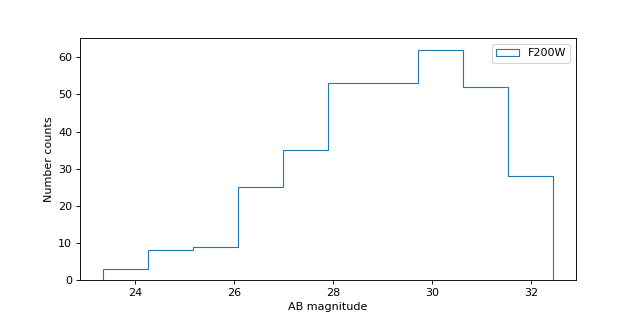

In [31]:
fig = plt.figure(figsize=(8, 4))

filt = 'F200W'
mag1 = tbl[filt + '_mag']

mag1 = mag1[(0 < mag1) & (mag1 < 90)]  # detections only
n = plt.hist(mag1, histtype='step', label=filt)

plt.xlabel('AB magnitude')
plt.ylabel('Number counts')
plt.legend()

## Plot F200W vs. F090W magnitudes and look for dropouts

Text(0, 0.5, 'F200W AB magnitude')

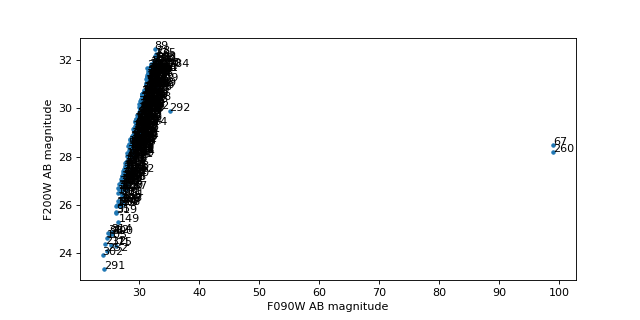

In [32]:
#import mplcursors
# Would love a better solution here!

mag1 = tbl['F090W_mag']
mag2 = tbl['F200W_mag']

# Only plot detections in F200W
det2 = (0 < mag2) & (mag2 < 90)

mag1 = mag1[det2]
mag2 = mag2[det2]
ids = tbl['label'][det2]

plt.figure(figsize=(8, 4))

plt.plot(mag1, mag2, '.')

for i in range(len(mag1)):
    plt.text(mag1[i], mag2[i], ids[i])

plt.xlabel('F090W AB magnitude')
plt.ylabel('F200W AB magnitude')

## Look at one object

In [33]:
# Could select object by position
#x, y = 905, 276
#id = segm.data[y,x]

# Select by ID number
id = 261  # F090W dropout
obj = tbl[id-1]

In [34]:
obj

label,xcentroid,ycentroid,sky_centroid,area,a,b,ellipticity,orientation,gini,F090W_flux,F090W_fluxerr,F090W_mag,F090W_magerr,F115W_flux,F115W_fluxerr,F115W_mag,F115W_magerr,F150W_flux,F150W_fluxerr,F150W_mag,F150W_magerr,F200W_flux,F200W_fluxerr,F200W_mag,F200W_magerr,F277W_flux,F277W_fluxerr,F277W_mag,F277W_magerr,F335M_flux,F335M_fluxerr,F335M_mag,F335M_magerr,F356W_flux,F356W_fluxerr,F356W_mag,F356W_magerr,F410M_flux,F410M_fluxerr,F410M_mag,F410M_magerr,F444W_flux,F444W_fluxerr,F444W_mag,F444W_magerr
,,,"deg,deg",pix2,pix,pix,,deg,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,
int64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
261,865.7937688069217,865.3938121370803,"53.17004553973157,-27.79818272548051",235.0,4.065538376574711,2.6927244116523616,0.33767089073181245,69.06589603566694,0.4315480391687005,41.68945562985641,2.686545367424479,27.34993443935462,0.06780484593178428,48.737965837992704,2.070950425162664,27.180331501982174,0.045181331122168815,81.5921003870553,3.0246374430939804,26.620879717220305,0.039520412887585815,97.94573053409367,3.457172705664489,26.422536225510417,0.037662198875427606,76.55946307269284,1.1392513193767568,26.690002802543297,0.01603738503306511,84.4882678049691,1.4166393574280562,26.58300898446933,0.018053916535232133,82.97603999232753,1.314028927361034,26.602618238979666,0.01705926132299369,75.42026752649357,1.4353437066283696,26.706279828557303,0.02046878071077726,72.47799342706129,1.6009162546130045,26.74948459681382,0.023721050885224165


In [35]:
obj['ellipticity']

<Quantity 0.33767089>

In [36]:
segmobj = segm.segments[segm.get_index(id)]
segmobj

<photutils.segmentation.core.Segment>
label: 261
slices: (slice(855, 876, None), slice(859, 874, None))
area: 235

## Show the object in all the images

Text(0, 0.5, 'Weight')

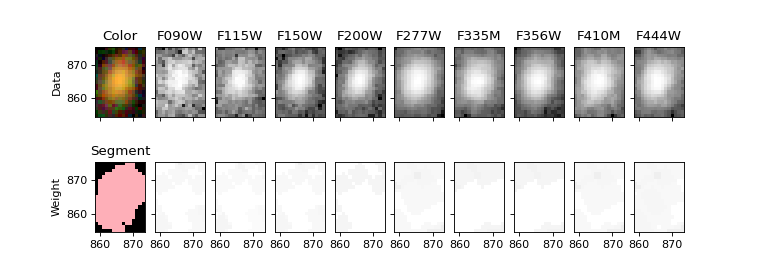

In [37]:
fig, ax = plt.subplots(2, len(filters)+1, figsize=(9.5, 3.5), sharex=True, sharey=True)

ax[0, 0].imshow(rgb[segmobj.slices], origin='lower', extent=segmobj.bbox.extent)
ax[0, 0].set_title('Color')

cmap = segm.make_cmap(seed=12345)  # ERROR
ax[1, 0].imshow(segm.data[segmobj.slices], origin='lower', extent=segmobj.bbox.extent, cmap=cmap,
               interpolation='nearest')
ax[1, 0].set_title('Segment')

for i in range(1, len(filters)+1):
    filt = filters[i-1]

    # Show data on top row
    data = fits.open(imagefiles[filt])[0].data
    stamp = data[segmobj.slices]
    norm = ImageNormalize(stretch=SqrtStretch())  # scale each filter individually
    ax[0, i].imshow(stamp, extent=segmobj.bbox.extent, cmap='Greys_r', norm=norm, origin='lower')
    ax[0, i].set_title(filt.upper())

    # Show weights on bottom row
    weight = fits.open(weightfiles[filt])[0].data
    stamp = weight[segmobj.slices]
    # set black to zero weight (no exposure time / bad pixel)
    ax[1, i].imshow(stamp, extent=segmobj.bbox.extent, vmin=0, cmap='Greys_r', origin='lower')

ax[0, 0].set_ylabel('Data')
ax[1, 0].set_ylabel('Weight')

## Plot SED (Spectral Energy Distribution)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

for filt in filters:
    lam = int(filt[1:4]) / 100
    plt.errorbar(lam, obj[filt+'_flux'].value, obj[filt+'_fluxerr'].value, marker='.', c='b')

plt.axhline(0, c='k', ls=':')
plt.xlim(0, 5)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux (nJy)')

mlim = 31.4
flim = mlim * u.ABmag
flim = flim.to(u.nJy).value

# Add AB magnitudes as secondary x-axis at right
# https://matplotlib.org/gallery/subplots_axes_and_figures/secondary_axis.html#sphx-glr-gallery-subplots-axes-and-figures-secondary-axis-py
def AB2nJy(mAB):
    m = mAB * u.ABmag
    f = m.to(u.nJy)
    f = f.value
    f = np.where(f > flim, f, flim)
    return f

def nJy2AB(F_nJy):
    f = F_nJy * u.nJy
    m = f.to(u.ABmag)
    m = m.value
    m = np.where(m < mlim, m, mlim)
    return m
    
plt.ylim(flim, plt.ylim()[1])

secax = ax.secondary_yaxis('right', functions=(nJy2AB, AB2nJy))
secax.set_ylabel('magnitude (AB)')

## Magnitude conversion fails for flux <= 0

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

for filt in filters:
    lam = int(filt[1:4]) / 100
    plt.errorbar(lam, obj[filt+'_flux'].value, obj[filt+'_fluxerr'].value, marker='.', c='b')

plt.axhline(0, c='k', ls=':')
plt.xlim(0, 5)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux (nJy)')

f0 = 10**(0.4 * 31.4)  # flux [nJy] at zero magnitude
b0 = 1.e-12  # this should be filter dependent

# Add AB magnitudes as secondary x-axis at right
# https://matplotlib.org/gallery/subplots_axes_and_figures/secondary_axis.html#sphx-glr-gallery-subplots-axes-and-figures-secondary-axis-py
def AB2nJy(m):
    f = np.sinh(-0.4 * m * np.log(10) - np.log(b0)) * 2 * b0 * f0
    return f

# Luptitudes
# https://www.sdss.org/dr12/algorithms/magnitudes/
def nJy2AB(f):
    m = -2.5 / np.log(10) * (np.arcsinh((f / f0) / (2 * b0)) + np.log(b0))
    return m

#plt.ylim(flim, plt.ylim()[1])

secax = ax.secondary_yaxis('right', functions=(nJy2AB, AB2nJy))
secax.set_ylabel('asinh magnitude (AB)')